In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from astropy.io import fits
from tqdm import tqdm_notebook
import pickle
import pymc3 as pm
import theano.tensor as tt
from os import listdir
from os.path import join
from pymc3.variational.callbacks import CheckParametersConvergence
import math
from collections import Counter

In [7]:
def get_light_curve(file_name, no_phase=True):
    with fits.open(file_name) as hdul:
        events = hdul[1].data
    times = np.sort(events['time'])
    if no_phase:
        times = times - times[0]
    return times

def kde_spike(times, sigma=1, resolution=1):
    times_grid = np.arange(times[0], times[-1], step=resolution)
    smooth_times = np.zeros(shape=times_grid.shape)
    for center in times:
        min_idx = np.argmin((times_grid - center + 5*sigma)**2)
        max_idx = np.argmin((times_grid - center - 5*sigma)**2)
        smooth_times[min_idx:max_idx] += np.exp(-0.5*(times_grid[min_idx:max_idx] - center)**2/sigma**2)
    #smooth_times = smooth_times*np.sqrt(2.0*np.pi)*sigma*len(times)
    return times_grid, smooth_times

def append_5k_chunked(lctmp):
    lc_chunked = list()
    maximo = np.amax(lctmp)
    num = math.ceil(maximo/2500.0)
    for i in range(num):
        tmp = lctmp[np.logical_and(lctmp>=(2500*i),lctmp<=(2500*i)+5000)]
        lc_times.append(tmp)
    return

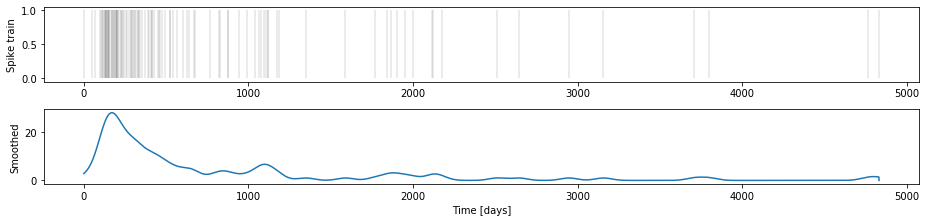

In [8]:
#light curve to compare with (template)
times_template = get_light_curve('XRAY/cut_evt2.fits')
times_template = times_template[np.logical_and(times_template>=0.0,times_template<=5000.0)]

tgrid, smoothed_lc = kde_spike(times_template, sigma=50, resolution=1)
fig = plt.figure(figsize=(13, 3))
ax = fig.add_subplot(2, 1, 1)
ax.vlines(times_template, ymin=0.0, ymax=1.0, alpha=0.1)
ax.set_ylabel('Spike train')
ax = fig.add_subplot(2, 1, 2)
ax.plot(tgrid, smoothed_lc)
plt.tight_layout()
ax.set_ylabel('Smoothed')
ax.set_xlabel('Time [days]');

  0%|          | 0/20000 [00:00<?, ?it/s]/home/jupyter/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 127.89: 100%|██████████| 20000/20000 [01:00<00:00, 328.90it/s]
Finished [100%]: Average Loss = 127.8


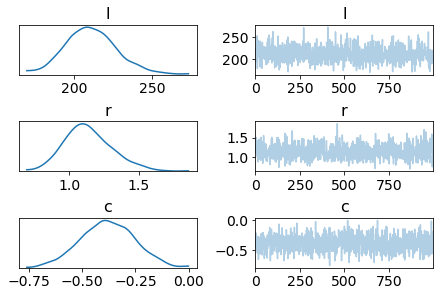

In [9]:
lc_times = list()
lc_times.append(times_template)

N = 100
beta = 0.5

#unique_elements, counts_elements = np.unique(times_template, return_counts=True)

counts_elements, unique_elements = np.histogram(times_template, bins=np.linspace(0, 5000, N), density=False)
unique_elements = (unique_elements[1:] + unique_elements[:-1])/2

with pm.Model() as model:
    # x(t) ~ N(0, Kt)
   
   
    l = pm.Gamma("l", alpha=100., beta=beta)
    r = pm.HalfCauchy("r", beta=10)
    c = pm.Normal("c", mu=0, sd=10)

    lmax = pm.HalfCauchy("lmax", beta=10)
    gp_x = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=c), cov_func=r*pm.gp.cov.ExpQuad(input_dim=1, ls=l))
    #gp_x = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=c), cov_func=r*pm.gp.cov.Matern52(input_dim=1, ls=l))

    x = gp_x.prior("x", X=unique_elements.reshape(-1, 1), reparameterize=True)
    
    h = pm.Deterministic('h', tt.exp(x))
    #h = pm.Deterministic('h', lmax/(1+tt.exp(-x)))
    train = pm.Poisson("y", mu=tt.reshape(h, (-1, 1)), observed=counts_elements.reshape(-1, 1))
    
    mean_field = pm.fit(n=20000, method='advi') #fullrank_advi
    #mean_field = pm.fit(n=100000, method='advi', callbacks=[pm.callbacks.CheckParametersConvergence(every=100, diff='relative', tolerance=0.09)] ) #fullrank_advi
    #mean_field = pm.fit(n=30000, method='advi', callbacks=[pm.callbacks.CheckParametersConvergence(every=100, tolerance=0.01, diff='relative')] ) #fullrank_advi

    trace = mean_field.sample(1000)

    pm.plots.traceplot(trace, var_names=['l', 'r', 'c'], figsize=(6, 4));


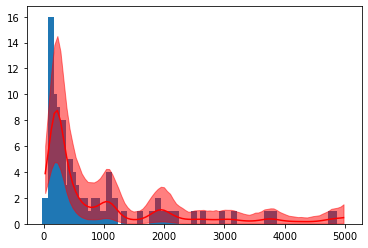

In [10]:
plt.figure()
mu = np.mean(trace['h'], axis=0)
err = np.percentile(trace['h'], q=(5, 95), axis=0)
plt.plot(unique_elements, mu, 'r');
plt.fill_between(unique_elements, err[0,:], err[1, :], color='r', alpha=0.5)
plt.bar(height=counts_elements, x=unique_elements, width=100, zorder=-1);

In [11]:
loo  = pm.loo(trace, model)
print(loo)

/home/jupyter/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 1000 by 99 log-likelihood matrix

       Estimate       SE
IC_loo   307.16    32.59
p_loo     62.50        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       14   14.1%
 (0.5, 0.7]   (ok)         23   23.2%
   (0.7, 1]   (bad)        37   37.4%
   (1, Inf)   (very bad)   25   25.3%



In [12]:
waic = pm.waic(trace, model)
print(waic)

Computed from 1000 by 99 log-likelihood matrix

        Estimate       SE
IC_waic   270.14    30.61
p_waic     43.99        -

There has been a warning during the calculation. Please check the results.


/home/jupyter/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7feb8fc88d10>,
      dtype=object)

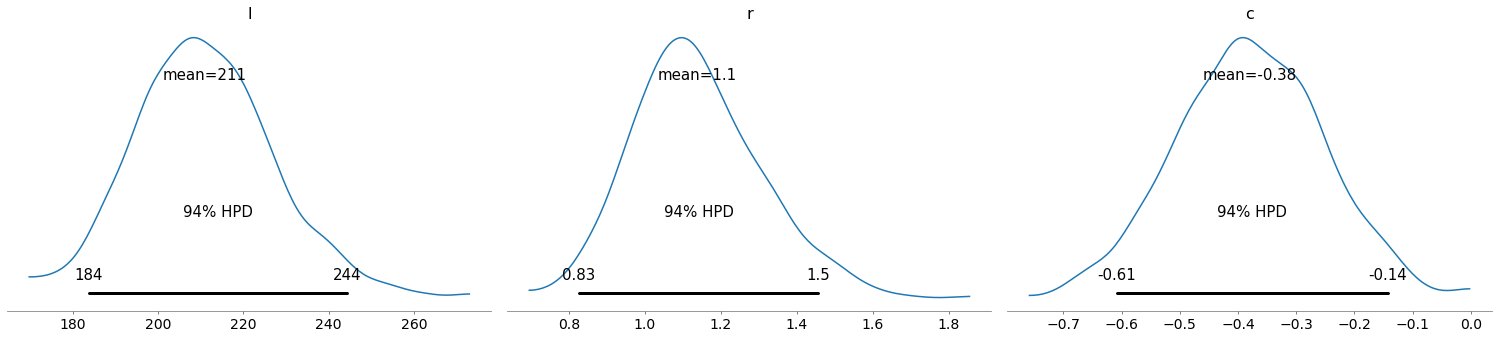

In [13]:
import arviz as az

az.plot_posterior(trace, var_names=['l','r','c'], kind='kde')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb742cc190>,
      dtype=object)

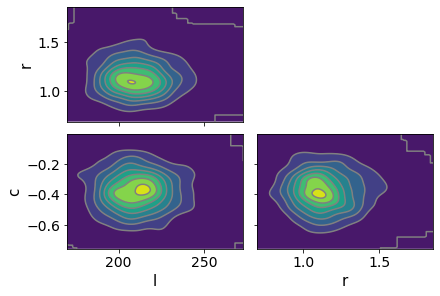

In [16]:
az.plot_pair(trace,var_names=['l','r','c'],kind='kde')